# Imports

In [1]:
# add reloading to jupyter
%load_ext autoreload
%autoreload 2

import sys
import os
import csv
from openmm import unit

# append parent dir to path using 
sys.path.append(os.path.join(os.getcwd(), '..'))


import matplotlib.pyplot as plt
from mcmc_eval_utils import *

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



# Constants

In [2]:
input_file = '../database.txt'

molecules_smiles = {}
with open(input_file, 'r') as infile:
    reader = csv.reader(infile, delimiter=';')
    for row in reader:
        if row[0].startswith('#'):
            continue  # Skip header or comment lines
        smiles = row[1]
        experimental_val = row[3]
        experimental_uncertainty = row[4]
        molecules_smiles[smiles] = experimental_val, experimental_uncertainty

In [3]:
batch_size = 32
kB = unit.BOLTZMANN_CONSTANT_kB.value_in_unit(unit.hartree/unit.kelvin)
beta=1/(kB*298.15)
hartree_to_kcal = 627.503
T = 298.15
ground_truth = float(molecules_smiles[' CCCCCC(=O)OC'][0])

run_mcmc_flag = True
run_brute_force = False



In [4]:
results_dict = {}

In [5]:

if run_brute_force:
    for k, v in molecules_smiles.items():
        i = 2000
        print('Running for {} with {} samples'.format(k, i*32))
        fed, samples = brute_force_fed(k, T, ground_truth=float(v[0]), uncertainty=float(v[1]), num_batches=i, batch_size=32)
        print('Error for {}: {}'.format(k, fed - float(v[0])))
        np.save('data/samples_brute_force.npy', samples.cpu().numpy())
        break

In [8]:
import numpy as np
import torch
import random

if run_mcmc_flag:
    v_energy = MoleculeFromSMILES_XTB('CCCCCCC(=O)OC', temp=T, solvate=False)
    s_energy = MoleculeFromSMILES_XTB('CCCCCCC(=O)OC', temp=T, solvate=True)

    # Assuming the molecule has 2 rotatable torsion angles for simplicity.
    n_dims = v_energy.data_ndim

    samples_v, sampler_v = run_mcmc(likelihood_v, n_dims, tries=1000, min_max=(-np.pi, np.pi), Rminus1_stop=5)
    samples_s, sampler_s = run_mcmc(likelihood_s, n_dims, tries=1000, min_max=(-np.pi, np.pi), Rminus1_stop=5)

    np.save('samples_v.npy', samples_v)
    np.save('samples_s.npy', samples_s)


[gfn] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: angle_0:0, angle_1:0, angle_2:0, angle_3:0, angle_4:0, angle_5:0, angle_6:0, angle_7:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gfn: 0.142}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-09-15 19:27:21 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.810
[mcmc]  - Convergence of means: R-1 = 30.802232 after 256 accepted steps
[mcmc] Convergence less than requested for updates: waiting until the next convergence check.
[mcmc] Progress @ 2024-09-15 19:28:21 : 781 steps taken, and 624 accepted.
[mcmc] Learn + convergence test @ 640 samples accepted.
[mcmc]  - Acceptance rate: 0.883
[mcmc]  - Convergence o

KeyboardInterrupt: 

In [7]:
bar_estimates = {}
partition_function_estimates = {}

### Free energy difference for brute force (BAR)

In [8]:
# Calculate the free energy difference
delta_f_kcal_bf, delta_f_error_kcal_bf, \
    overlap_bf, v_energies_bf, s_energies_bf = bar_estimate(v_file='data/samples_brute_force.npy', s_file='data/samples_brute_force.npy', beta=beta, subsample=10000)

bar_estimates['brute_force'] = delta_f_kcal_bf

print(f"Overlap: {overlap_bf:.4f}")
print(f"Free energy difference: {delta_f_kcal_bf:.2f} ± {delta_f_error_kcal_bf:.2f} kcal/mol")

100%|██████████| 1250/1250 [12:59<00:00,  1.60it/s]
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:494: RuntimeWarning: divide by zero encountered in log
  log_fF = -np.log(np.exp(-max_arg_F) + np.exp(exp_arg_F - max_arg_F))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:500: RuntimeWarning: divide by zero encountered in log
  log_fR = -np.log(np.exp(-max_arg_R) + np.exp(exp_arg_R - max_arg_R))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:509: RuntimeWarning: invalid value encountered in scalar divide
  variance = (afF2 / afF**2) / T_F + (afR2 / afR**2) / T_R - nrat

******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

2024-09-09 17:24:31.474839: W external/x

Overlap: 0.0136
Free energy difference: -18.73 ± nan kcal/mol


/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:494: RuntimeWarning: divide by zero encountered in log
  log_fF = -np.log(np.exp(-max_arg_F) + np.exp(exp_arg_F - max_arg_F))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:500: RuntimeWarning: divide by zero encountered in log
  log_fR = -np.log(np.exp(-max_arg_R) + np.exp(exp_arg_R - max_arg_R))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:509: RuntimeWarning: invalid value encountered in scalar divide
  variance = (afF2 / afF**2) / T_F + (afR2 / afR**2) / T_R - nrat


In [9]:
delta_f_kcal_bf = fed_estimate_Z(v_energies_bf, s_energies_bf, beta_applied=False)
partition_function_estimates['brute_force'] = delta_f_kcal_bf
partition_function_estimates['brute_force']

tensor(-5.5586)

### Free energy difference for mcmc samples (BAR)

In [52]:
# Calculate the free energy difference
delta_f_kcal_mcmc, delta_f_error_kcal_mcmc, overlap_mcmc, vv_energies_mcmc, ss_energies_mcmc, vs_energies_mcmc, sv_energies_mcmc, exp_avg_f_mcmc, exp_avg_b_mcmc = bar_estimate(v_file='data/samples_v.npy', s_file='data/samples_s.npy', beta=beta)

bar_estimates['mcmc'] = delta_f_kcal_mcmc

print(f"Overlap: {overlap_mcmc:.4f}")
print(f"Free energy difference: {delta_f_kcal_mcmc:.2f} ± {delta_f_error_kcal_mcmc:.2f} kcal/mol")

100%|██████████| 1280/1280 [10:12<00:00,  2.09it/s]
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:494: RuntimeWarning: divide by zero encountered in log
  log_fF = -np.log(np.exp(-max_arg_F) + np.exp(exp_arg_F - max_arg_F))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:500: RuntimeWarning: divide by zero encountered in log
  log_fR = -np.log(np.exp(-max_arg_R) + np.exp(exp_arg_R - max_arg_R))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:509: RuntimeWarning: invalid value encountered in scalar divide
  variance = (afF2 / afF**2) / T_F + (afR2 / afR**2) / T_R - nrat


Overlap: 0.2000
Free energy difference: -6.16 ± nan kcal/mol


/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:494: RuntimeWarning: divide by zero encountered in log
  log_fF = -np.log(np.exp(-max_arg_F) + np.exp(exp_arg_F - max_arg_F))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:500: RuntimeWarning: divide by zero encountered in log
  log_fR = -np.log(np.exp(-max_arg_R) + np.exp(exp_arg_R - max_arg_R))
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/pymbar/other_estimators.py:509: RuntimeWarning: invalid value encountered in scalar divide
  variance = (afF2 / afF**2) / T_F + (afR2 / afR**2) / T_R - nrat


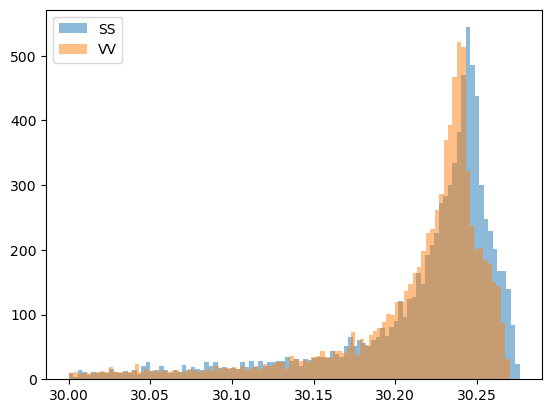

In [60]:
# plot mcmc energy distributions
plt.hist(-ss_energies_mcmc[-ss_energies_mcmc>30], bins=100, alpha=0.5, label='SS')
plt.hist(-vv_energies_mcmc[-vv_energies_mcmc>30], bins=100, alpha=0.5, label='VV')
plt.legend()
plt.show()

In [66]:
delta_f_kcal_mcmc = fed_estimate_Z(vv_energies_mcmc, ss_energies_mcmc, beta_applied=False)
partition_function_estimates['mcmc'] = delta_f_kcal_mcmc
delta_f_kcal_mcmc

tensor(-3.9473)

### Free energy difference for GFN samples (BAR)

In [9]:
gfn_bars = []
gfn_fedzs = []
gfn_exp_avg_f = []
gfn_exp_avg_b = []

vv_energies_gfn = []
ss_energies_gfn = []
vs_energies_gfn = []
sv_energies_gfn = []


# Calculate the free energy difference
delta_f_kcal_gfn, delta_f_error_kcal_gfn, overlap_gfn, vv_energies, ss_energies, vs_energies, sv_energies, exp_avg_f, exp_avg_b = \
    bar_estimate(v_file=f'data/False/states.npy', s_file=f'data/True/states.npy', beta=1)


vv_energies_gfn.extend(vv_energies)
ss_energies_gfn.extend(ss_energies)
vs_energies_gfn.extend(vs_energies)
sv_energies_gfn.extend(sv_energies)

gfn_bars.append(delta_f_kcal_gfn)
gfn_exp_avg_f.append(exp_avg_f)
gfn_exp_avg_b.append(exp_avg_b)
print(f"Overlap: {overlap_gfn:.4f}")
print(f"BAR: {delta_f_kcal_gfn:.2f} ± {delta_f_error_kcal_gfn:.2f} kcal/mol")

print(f"Exp avg forward: {exp_avg_f:.2f}")
print(f"Exp avg reverse: {exp_avg_b:.2f}")

delta_f_kcal_gfn = fed_estimate_Z(vv_energies, ss_energies, beta_applied=True)

print(f"Z: {delta_f_kcal_gfn:.2f} kcal/mol")
gfn_fedzs.append(delta_f_kcal_gfn)


bar_estimates[f'gfn'] = np.mean(gfn_bars)
partition_function_estimates[f'gfn'] = np.mean(gfn_fedzs)

100%|██████████| 1536/1536 [11:48<00:00,  2.17it/s]

******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

2024-09-15 12:55:45.940710: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Overlap: 0.9689
BAR: -4.17 ± 0.00 kcal/mol
Exp avg forward: -4.10
Exp avg reverse: -3.68
Z: -1.64 kcal/mol


In [10]:
# # save the energy lists as np arrays
np.save('data/vv_energies_gfn.npy', vv_energies_gfn)
np.save('data/ss_energies_gfn.npy', ss_energies_gfn)
np.save('data/vs_energies_gfn.npy', vs_energies_gfn)
np.save('data/sv_energies_gfn.npy', sv_energies_gfn)

In [11]:
vv_energies_gfn = torch.from_numpy(np.load('data/vv_energies_gfn.npy'))
ss_energies_gfn = torch.from_numpy(np.load('data/ss_energies_gfn.npy'))
vs_energies_gfn = torch.from_numpy(np.load('data/vs_energies_gfn.npy'))
sv_energies_gfn = torch.from_numpy(np.load('data/sv_energies_gfn.npy'))

In [12]:
v_pfs = torch.from_numpy(np.load('data/False/log_pfs.npy'))
s_pfs = torch.from_numpy(np.load('data/True/log_pfs.npy'))

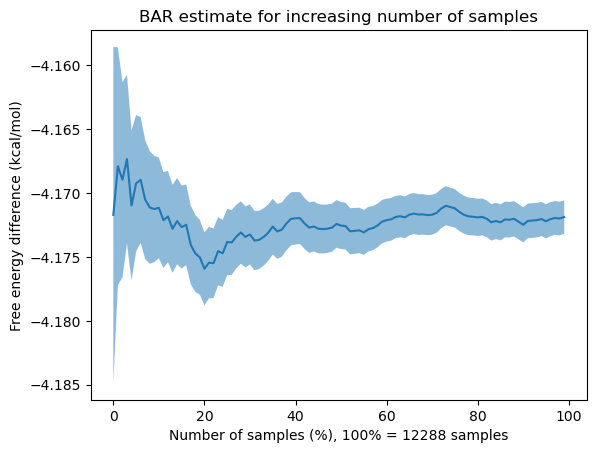

In [13]:
# w_F = ((sv_energies - vv_energies)*beta).cpu().numpy()
# w_R = ((vs_energies - ss_energies)*beta).cpu().numpy()
# create w_F and w_R like above for an increasing number of samples (do it 10% wise, 10 times)
# then do     result = pymbar.other_estimators.bar(w_F, w_R) for each of the 10% wise samples
# then plot them

bar_results = []
bar_uncertainties = []
steps = 100
N = len(sv_energies_gfn)
for i in range(1, steps+1):
    w_F = ((np.array(sv_energies_gfn[:N//steps*i]) - np.array(vv_energies_gfn[:N//steps*i])))
    w_R = ((np.array(vs_energies_gfn[:N//steps*i]) - np.array(ss_energies_gfn[:N//steps*i])))
    result = pymbar.other_estimators.bar(w_F, w_R)
    bar_results.append(result['Delta_f'] * kB * T * hartree_to_kcal)
    bar_uncertainties.append(result['dDelta_f'] * kB * T * hartree_to_kcal)

plt.plot(bar_results)
plt.fill_between(range(steps), np.array(bar_results) - np.array(bar_uncertainties), np.array(bar_results) + np.array(bar_uncertainties), alpha=0.5)
plt.title('BAR estimate for increasing number of samples')
plt.xlabel(f'Number of samples (%), 100% = {N} samples')
plt.ylabel('Free energy difference (kcal/mol)')
plt.show()


### pymbar bar/fwd/bwd

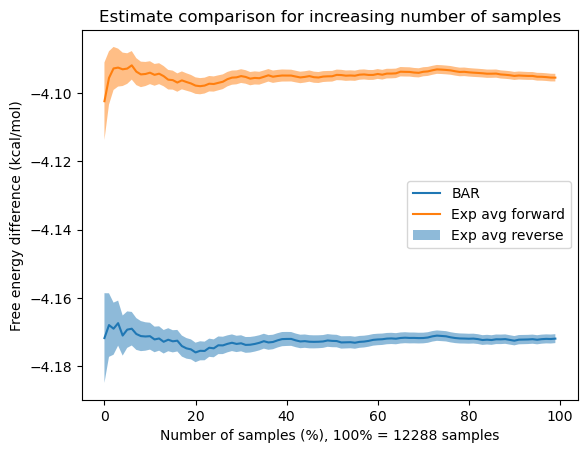

In [14]:
# do the same for     exp_avg_f = pymbar.other_estimators.exp(w_F)

exp_avg_f_results = []
exp_avg_f_uncertainties = []
exp_avg_r_results = []
exp_avg_r_uncertainties = []
steps = 100
N = len(sv_energies_gfn)
for i in range(1, steps+1):
    w_F = ((np.array(sv_energies_gfn[:N//steps*i]) - np.array(vv_energies_gfn[:N//steps*i])))
    exp_avg_f = pymbar.other_estimators.exp(w_F)
    exp_avg_f_results.append(exp_avg_f['Delta_f']*kB*T*hartree_to_kcal)
    exp_avg_f_uncertainties.append(exp_avg_f['dDelta_f']*kB*T*hartree_to_kcal)

    w_R = ((np.array(vs_energies_gfn[:N//steps*i]) - np.array(ss_energies_gfn[:N//steps*i])))
    exp_avg_r = pymbar.other_estimators.exp(w_R)
    exp_avg_r_results.append(exp_avg_r['Delta_f']*kB*T*hartree_to_kcal)
    exp_avg_r_uncertainties.append(exp_avg_r['dDelta_f']*kB*T*hartree_to_kcal)

plt.plot(bar_results)
plt.plot(exp_avg_f_results)
# plt.plot(exp_avg_r_results)
plt.fill_between(range(steps), np.array(bar_results) - np.array(bar_uncertainties), np.array(bar_results) + np.array(bar_uncertainties), alpha=0.5)
plt.fill_between(range(steps), np.array(exp_avg_f_results) - np.array(exp_avg_f_uncertainties), np.array(exp_avg_f_results) + np.array(exp_avg_f_uncertainties), alpha=0.5)
# plt.fill_between(range(steps), np.array(exp_avg_r_results) - np.array(exp_avg_r_uncertainties), np.array(exp_avg_r_results) + np.array(exp_avg_r_uncertainties), alpha=0.5)

plt.title('Estimate comparison for increasing number of samples')
plt.xlabel(f'Number of samples (%), 100% = {N} samples')
plt.ylabel('Free energy difference (kcal/mol)')
plt.legend(['BAR', 'Exp avg forward', 'Exp avg reverse'])
plt.show()


In [15]:
torch.stack(vv_energies_gfn)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [16]:
def calc_NSS(energies, pfs, beta):
    exponents = energies*beta - pfs.sum(-1)
    exponents = exponents - exponents.max()
    weights = torch.exp(exponents)
    weights = weights / weights.sum()
    NSS = torch.exp(-torch.sum(weights*torch.log(weights)))
    N = len(energies)
    return NSS,NSS/N


calc_NSS(vv_energies_gfn, v_pfs, 1), calc_NSS(vv_energies_gfn, v_pfs, 1),  calc_NSS(ss_energies_gfn, s_pfs, 1), calc_NSS(ss_energies_gfn, s_pfs, 1)

((tensor(1.1264), tensor(9.1669e-05)),
 (tensor(1.1264), tensor(9.1669e-05)),
 (tensor(nan), tensor(nan)),
 (tensor(nan), tensor(nan)))

In [18]:


def weigh_samples(energies, pfs, beta):
    exponents = energies * beta - pfs.sum(dim=-1)
    exponents -= exponents.max()
    weights = torch.exp(exponents)
    weights /= weights.sum()
    weights = torch.where(weights > 1e-10, weights, torch.tensor(1e-10))
    return torch.sum(energies * weights, dim=-1)

In [19]:
v_weights = compute_weights(vv_energies_gfn, v_pfs, 1)
s_weights = compute_weights(ss_energies_gfn, s_pfs, 1)

vv_energies_gfn = torch.stack(vv_energies_gfn)
ss_energies_gfn = torch.stack(ss_energies_gfn)
vs_energies_gfn = torch.stack(vs_energies_gfn)
sv_energies_gfn = torch.stack(sv_energies_gfn)

NameError: name 'compute_weights' is not defined

In [20]:
import numpy as np

def compute_free_energy_difference(ss_energies, sv_energies, vs_energies, vv_energies, tol=1e-6, max_iter=100):
    """
    Estimates the free energy difference between solvation and vacuum using the BAR method.

    Args:
        ss_energies: List or array of beta*energy for solvation energies computed on solvation states.
        sv_energies: List or array of beta*energy for solvation energies computed on vacuum states.
        vs_energies: List or array of beta*energy for vacuum energies computed on solvation states.
        vv_energies: List or array of beta*energy for vacuum energies computed on vacuum states.
        tol: Tolerance for convergence in the bisection method.
        max_iter: Maximum number of iterations in the bisection method.

    Returns:
        df: The estimated free energy difference between solvation and vacuum.
    """

    # Convert inputs to numpy arrays
    ss_energies = np.array(ss_energies)
    sv_energies = np.array(sv_energies)
    vs_energies = np.array(vs_energies)
    vv_energies = np.array(vv_energies)

    # Calculate energy differences
    dV_p = ss_energies - sv_energies  # Delta V for solvation ensemble
    dV_0 = vs_energies - vv_energies  # Delta V for vacuum ensemble

    # Since energies are already beta * energy, we set beta = 1
    beta = 1.0

    # Initial guesses for df using exponential averages
    exponent_p = -beta * dV_p
    exponent_0 = -beta * dV_0

    max_exp_p = np.max(exponent_p)
    max_exp_0 = np.max(exponent_0)

    # Shift exponents for numerical stability
    exp_p = np.exp(exponent_p - max_exp_p)
    exp_0 = np.exp(exponent_0 - max_exp_0)

    df_p = - (np.log(np.sum(exp_p)) + max_exp_p - np.log(len(dV_p))) / beta
    df_0 = - (np.log(np.sum(exp_0)) + max_exp_0 - np.log(len(dV_0))) / beta

    # Initialize interval for bisection
    df_min = min(df_p, df_0)
    df_max = max(df_p, df_0)

    def bar_residual(df):
        exponent_p = beta * (dV_p - df)
        exponent_0 = beta * (-dV_0 + df)
        gf = 1.0 / (1.0 + np.exp(exponent_p))
        gr = 1.0 / (1.0 + np.exp(exponent_0))
        return np.mean(gf) - np.mean(gr)

    res_min = bar_residual(df_min)
    res_max = bar_residual(df_max)

    # Expand interval if necessary
    if res_min * res_max > 0:
        df_expand = 1.0
        while res_min * res_max > 0 and df_expand < 1e6:
            df_min -= df_expand
            df_max += df_expand
            res_min = bar_residual(df_min)
            res_max = bar_residual(df_max)
            df_expand *= 2
        if res_min * res_max > 0:
            raise ValueError('Cannot find a valid interval for bisection.')

    # Bisection method to solve for df
    for _ in range(max_iter):
        df_mid = 0.5 * (df_min + df_max)
        res_mid = bar_residual(df_mid)
        if abs(res_mid) < tol:
            df = df_mid
            break
        if res_min * res_mid < 0:
            df_max = df_mid
            res_max = res_mid
        else:
            df_min = df_mid
            res_min = res_mid
    else:
        df = df_mid
        print('Warning: Maximum iterations reached in bisection method.')

    return df

In [21]:
compute_free_energy_difference(ss_energies_gfn, sv_energies_gfn, vs_energies_gfn, vv_energies_gfn, tol=1e-8, max_iter=100000) * kB * T * hartree_to_kcal

/tmp/ipykernel_3697878/847221932.py:53: RuntimeWarning: overflow encountered in exp
  gf = 1.0 / (1.0 + np.exp(exponent_p))


6.577556952943441

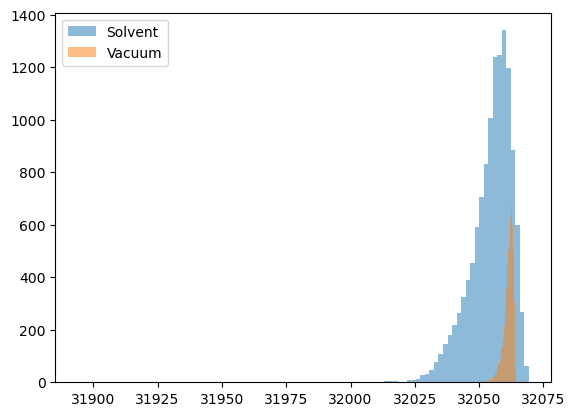

In [22]:
# read in data/False/log_r_{i}.npy, concat them and plot (and same for /True/)
log_r_false = np.load(f'data/False/log_r.npy')
log_r_true = np.load(f'data/True/log_r.npy')


plt.hist(log_r_true[log_r_true>30], bins=100, alpha=0.5, label='Solvent')

plt.hist(log_r_false[log_r_false>30], bins=100, alpha=0.5, label='Vacuum')

plt.legend()
plt.show()

In [23]:
from scipy.integrate import simps

densities = v_pfs.exp().mean(dim=-1).numpy()
points = np.arange(len(densities))

np.mean(densities)

5.1125445

tensor(1.0000) tensor(1.)


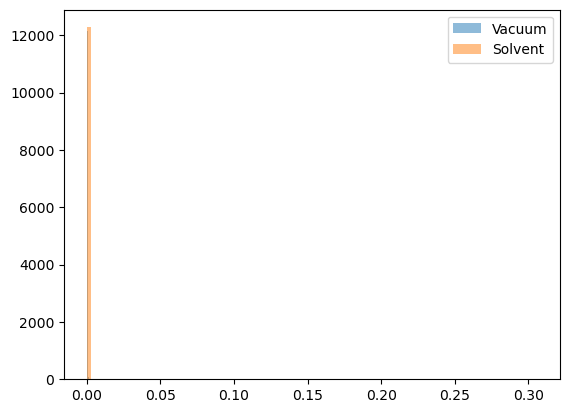

((tensor(1115.9563), tensor(0.0908)), (tensor(nan), tensor(nan)))

In [24]:
def compute_weights(energies, pfs, beta=1):
    exponents = energies - pfs.sum(dim=-1)
    exponents -= exponents.max()
    weights = torch.exp(exponents)
    weights /= weights.sum()
    return weights

def calc_NSS(energies, pfs, beta):
    exponents = energies - pfs.sum(-1)#*beta
    exponents = exponents - exponents.max()
    weights = torch.exp(exponents)
    weights = weights / weights.sum()
    NSS = torch.exp(-torch.sum(weights*torch.log(weights)))
    N = len(energies)
    return NSS,NSS/N

weights_v = compute_weights(torch.from_numpy(log_r_false), v_pfs, beta)
weights_s = compute_weights(torch.from_numpy(log_r_true), s_pfs, beta)

print(weights_v.sum(), weights_s.sum())

plt.hist(weights_v[weights_v<0.5], bins=100, alpha=0.5, label='Vacuum')
plt.hist(weights_s[weights_s<0.5], bins=100, alpha=0.5, label='Solvent')
plt.legend()
plt.show()
calc_NSS(torch.from_numpy(log_r_false), v_pfs, beta), calc_NSS(torch.from_numpy(log_r_true), s_pfs, beta)

In [25]:
def weighted_EXP(energies_A, energies_B, weights):
    exponents = (energies_A - energies_B) # sv is solvation energies on vacuum samples 
    weighted = torch.exp(exponents) * weights
    weighted_sum = weighted.sum()
    return torch.log(weighted_sum)

In [28]:
weighted_EXP(sv_energies_gfn, vv_energies_gfn, weights_v)*kB*T*hartree_to_kcal, weighted_EXP(ss_energies_gfn, vs_energies_gfn, weights_s)*kB*T*hartree_to_kcal

(tensor(-4.0695), tensor(-4.3651))

In [30]:
w_F = sv_energies_gfn - vv_energies_gfn
w_R = vs_energies_gfn - ss_energies_gfn

pymbar.other_estimators.exp(w_F.numpy())['Delta_f']*kB*T*hartree_to_kcal, pymbar.other_estimators.exp(w_R.numpy())['Delta_f']*kB*T*hartree_to_kcal

(-4.095444385867255, -3.6797973515669717)

In [30]:
# import getdist.plots as gdplt
# from getdist import plots
# %matplotlib inline

# gdsamples = sampler.products(to_getdist=True)["sample"]
# gdplot = gdplt.get_subplot_plotter(width_inch=5)
# gdplot.triangle_plot(gdsamples, [f"angle_{i}" for i in range(8)], filled=True)
# print(gdsamples.PCA(['angle_0', 'angle_1', 'angle_2', 'angle_3', 'angle_4', 'angle_5', 'angle_6', 'angle_7']))
# # 1D marginalized plot
# g = plots.get_single_plotter(width_inch=4)
# g.plot_1d(gdsamples, 'angle_0')
# plt.plot(np.abs(np.array(feds) - ground_truth))

# # add the ground truth value
# plt.axhline(y=0, color='r', linestyle='-')

# # increase x scale by step size (just visual), 
# plt.xticks(range(0, len(feds), 1), range(0, len(feds)*step, step))

# plt.xscale('log')
# plt.xlabel(f'Number of samples')
# plt.legend(['FED', 'Zero'])
# plt.show()


In [31]:
from utils import logmeanexp
from mcmc_eval_utils import T, kB, hartree_to_kcal

feds_logw = []
log_bw_v = f'data/False/log_beta_weight.npy'
log_bw_s = f'data/True/log_beta_weight.npy'


log_bw_v = torch.from_numpy(np.load(log_bw_v)) 
log_bw_s = torch.from_numpy(np.load(log_bw_s))

logw_V = -logmeanexp(log_bw_v) * kB*T*hartree_to_kcal
logw_S = -logmeanexp(log_bw_s) * kB*T*hartree_to_kcal

fed_logw = logw_S  - logw_V
# fed_logw = fed_estimate_Z_from_file(log_bw_v, log_bw_s, beta_applied=True)


feds_logw.append(fed_logw)
print(f'FED: {fed_logw}')

FED: -5.3671875


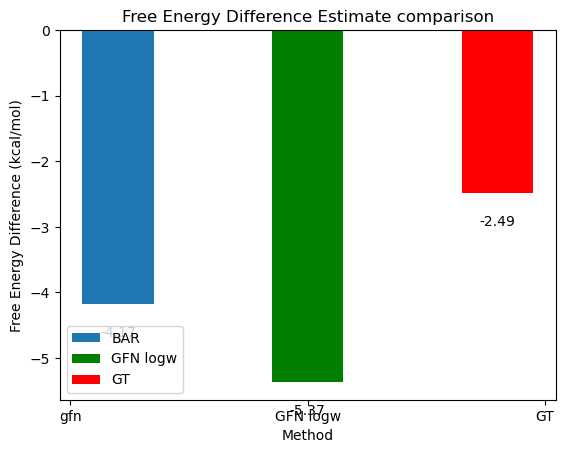

In [32]:
# plot BAR and partition function estimates on the same plot
# plot BAR and partition function estimates on the same plot
# plt.bar(np.arange(len(partition_function_estimates))+0.6, list(partition_function_estimates.values()), width=0.3, align='center', label='Partition Function')
plt.bar(np.arange(len(bar_estimates))+0.2, list(bar_estimates.values()), width=0.3, align='center', label='BAR')
# add a single bar for the ground truth value to the rightmost side of the plot
plt.bar(len(bar_estimates), np.mean(feds_logw), width=0.3, color='g', label='GFN logw')
plt.bar(len(bar_estimates)+0.8, ground_truth, width=0.3, color='r', label='GT')

plt.legend()
plt.xticks(range(len(bar_estimates)+2), list(bar_estimates.keys()) + ['GFN logw', 'GT'])
# add values to bars
vertical_offset = 0.5
# for i, v in enumerate(list(partition_function_estimates.values())):
#     plt.text(i+0.6, v - vertical_offset, f'{v:.2f}', ha='center')
for i, v in enumerate(list(bar_estimates.values())):
    plt.text(i+0.2, v - vertical_offset, f'{v:.2f}', ha='center')
plt.text(len(bar_estimates), fed_logw - vertical_offset, f'{fed_logw:.2f}', ha='center')
plt.text(len(bar_estimates)+0.8, ground_truth - vertical_offset, f'{ground_truth:.2f}', ha='center')

plt.xlabel('Method')
plt.ylabel('Free Energy Difference (kcal/mol)')
plt.title('Free Energy Difference Estimate comparison')
plt.show()
# # add a single bar for the fed_logw value to the rightmost side of the plot
# plt.bar(len(bar_estimates), fed_logw, color='g')
# plt.bar(len(bar_estimates)+1, ground_truth, color='r')

# plt.legend(['BAR', 'Partition Function', 'GFN logw', 'GT'])
# plt.xticks(range(len(bar_estimates)+2), list(bar_estimates.keys()) + ['GFN logw', 'GT'])

# plt.xlabel('Method')
# plt.ylabel('Free Energy Difference (kcal/mol)')
# plt.title('Free Energy Difference Estimate comparison')
# # set ylog
# plt.show()

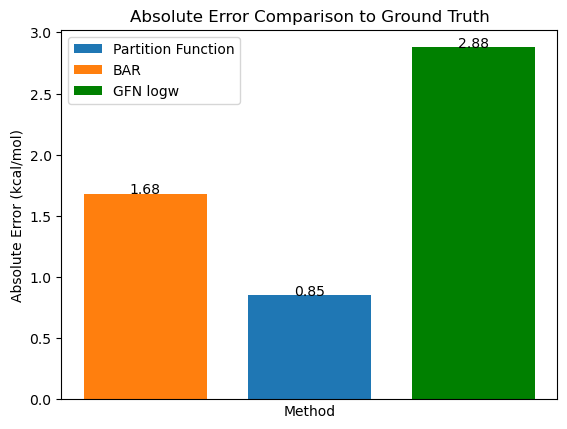

In [33]:
# do the exact same plot as above but this time plot the difference to the ground truth 
# plot BAR and partition function estimates on the same plot
plt.bar(np.arange(len(partition_function_estimates))+0.6, np.abs(np.array(list(partition_function_estimates.values())) - ground_truth), width=0.3, align='center', label='Partition Function')
plt.bar(np.arange(len(bar_estimates))+0.2, np.abs(np.array(list(bar_estimates.values())) - ground_truth), width=0.3, align='center', label='BAR')
# add a single bar for the ground truth value to the rightmost side of the plot
plt.bar(len(bar_estimates), np.abs(fed_logw - ground_truth), width=0.3, color='g', label='GFN logw')
# plt.bar(len(bar_estimates)+0.8, 0, width=0.3, color='r', label='GT')

# add error bars on bar estimates and partition function estimates from the lists above



plt.legend()
# remove xticks
plt.xticks([])
# change the last tick location only
# plt.xticks(range(len(bar_estimates)+1), list(bar_estimates.keys()) + ['GFN logw'])

# add values to bars
vertical_offset = -0
for i, v in enumerate(np.abs(np.array(list(partition_function_estimates.values())) - ground_truth)):
    plt.text(i+0.6, v - vertical_offset, f'{v:.2f}', ha='center')
for i, v in enumerate(np.abs(np.array(list(bar_estimates.values())) - ground_truth)):
    plt.text(i+0.2, v - vertical_offset, f'{v:.2f}', ha='center')
plt.text(len(bar_estimates), np.abs(fed_logw - ground_truth) - vertical_offset, f'{np.abs(fed_logw - ground_truth):.2f}', ha='center')
# plt.text(len(bar_estimates)+0.8, 0 - vertical_offset, f'{0:.2f}', ha='center')

plt.xlabel('Method')
plt.ylabel('Absolute Error (kcal/mol)')
plt.title('Absolute Error Comparison to Ground Truth')
plt.show()


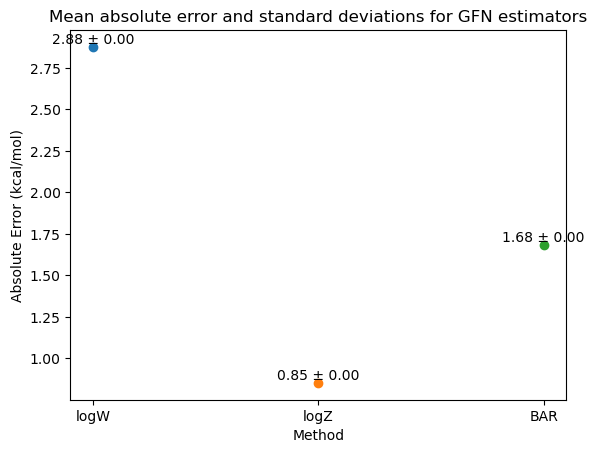

In [34]:
# Calculate the mean and standard deviations
mean_gfn_fedzs = np.mean(np.abs(np.array(gfn_fedzs) - ground_truth))
std_gfn_fedzs = np.std(np.abs(np.array(gfn_fedzs) - ground_truth))
mean_gfn_bars = np.mean(np.abs(np.array(gfn_bars) - ground_truth))
std_gfn_bars = np.std(np.abs(np.array(gfn_bars) - ground_truth))
mean_gfn_logw = np.mean(np.abs(np.array(feds_logw) - ground_truth))
std_gfn_logw = np.std(np.abs(np.array(feds_logw) - ground_truth))

# Plot the mean and standard deviations with error bars
plt.errorbar(0, mean_gfn_logw, yerr=std_gfn_logw, fmt='o', label='GFN logw')
plt.errorbar(1, mean_gfn_fedzs, yerr=std_gfn_fedzs, fmt='o', label='GFN fedzs')
plt.errorbar(2, mean_gfn_bars, yerr=std_gfn_bars, fmt='o', label='GFN bars')


# add text to means +- std
plt.text(0, mean_gfn_logw + 0.02, f'{mean_gfn_logw:.2f} ± {std_gfn_logw:.2f}', ha='center')
plt.text(1, mean_gfn_fedzs + 0.02, f'{mean_gfn_fedzs:.2f} ± {std_gfn_fedzs:.2f}', ha='center')
plt.text(2, mean_gfn_bars + 0.02, f'{mean_gfn_bars:.2f} ± {std_gfn_bars:.2f}', ha='center')

plt.xticks([0, 1, 2], ['logW', 'logZ', 'BAR'])

plt.xlabel('Method')
plt.ylabel('Absolute Error (kcal/mol)')
plt.title('Mean absolute error and standard deviations for GFN estimators')
plt.show()


In [35]:
from openmm import unit



In [36]:
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilocalorie_per_mole/unit.kelvin)
T = 298.15

e = -32 * 627

e / (kB * T) 

-33864.15133362146